In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2
import numpy as np

# Load the dataset
data = pd.read_csv('social_engagement_balanced.csv')

# Define features and target
X = data.drop(['text_data', 'overloaded'], axis=1)
y = data['overloaded'].astype(int)

# Apply one-hot encoding to categorical features
X = pd.get_dummies(X, columns=['event_type', 'location', 'time_of_day'], drop_first=True)

# Standardize numerical features
scaler = StandardScaler()
numerical_features = ['duration', 'engagement_level']
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Build the improved neural network model
model = Sequential([
    Input(shape=(X_train_smote.shape[1],)),
    Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train_smote, y_train_smote, epochs=20, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')


Epoch 1/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.8967 - loss: 0.7790 - val_accuracy: 0.9980 - val_loss: 0.4265
Epoch 2/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9656 - loss: 0.4600 - val_accuracy: 1.0000 - val_loss: 0.2716
Epoch 3/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9835 - loss: 0.2892 - val_accuracy: 1.0000 - val_loss: 0.1699
Epoch 4/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9905 - loss: 0.1834 - val_accuracy: 1.0000 - val_loss: 0.1166
Epoch 5/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.9956 - loss: 0.1196 - val_accuracy: 1.0000 - val_loss: 0.0833
Epoch 6/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9951 - loss: 0.0961 - val_accuracy: 1.0000 - val_loss: 0.0719
Epoch 7/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.9948 - loss: 0.0862 - val_accuracy: 1.0000 - val_loss: 0.0581
Epoch 8/20
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9951 - loss: 0.

In [2]:
model.save('analysis.h5')

In [5]:
import shap
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import numpy as np

def analyze_feature_importance(model, X_test):
    def get_feature_importance(model, X):
    # Convert DataFrame to tensor
    X_tensor = tf.convert_to_tensor(X.values, dtype=tf.float32)
    baseline_pred = model.predict(X_tensor, verbose=0)
    importances = {}
    
    # Calculate baseline variance
    baseline_var = np.var(baseline_pred)
    
    for i, column in enumerate(X.columns):
        importance_scores = []
        # Multiple permutations for more stable results
        for _ in range(5):
            X_permuted = X.copy().values
            # Shuffle the column values instead of adding noise
            np.random.shuffle(X_permuted[:, i])
            X_permuted_tensor = tf.convert_to_tensor(X_permuted, dtype=tf.float32)
            permuted_pred = model.predict(X_permuted_tensor, verbose=0)
            
            # Calculate importance using prediction variance
            importance = np.var(baseline_pred - permuted_pred) / (baseline_var + 1e-10)
            importance_scores.append(importance)
        
        # Take the mean importance across permutations
        importances[column] = np.mean(importance_scores)
    
    # Normalize importances to sum to 100
    total = sum(importances.values())
    importances = {k: (v/total) * 100 for k, v in importances.items()}
    
    # Ensure no single feature dominates completely
    max_importance = 50  # Maximum allowed importance for any feature
    if max(importances.values()) > max_importance:
        scale_factor = max_importance / max(importances.values())
        importances = {k: v * scale_factor for k, v in importances.items()}
        # Redistribute remaining importance
        remaining = 100 - sum(importances.values())
        n_features = len(importances)
        for k in importances:
            importances[k] += remaining / n_features
    
    return importances
           
       
    
    # Use a smaller subset for efficiency
    sample_size = min(100, len(X_test))
    X_sample = X_test.head(sample_size)
    
    # Calculate feature importance
    feature_importance = get_feature_importance(model, X_sample)
    
    # Normalize importance scores
    max_importance = max(feature_importance.values())
    if max_importance > 0:  # Avoid division by zero
        feature_importance = {k: v/max_importance for k, v in feature_importance.items()}
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    importance_df = pd.DataFrame(list(feature_importance.items()), 
                               columns=['Feature', 'Importance'])
    importance_df = importance_df.sort_values('Importance', ascending=True)
    
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.title('Feature Importance Analysis')
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

def predict_and_analyze(input_data, model, scaler, X_test):
    """Main function to predict and provide detailed analysis"""
    # Preprocess input
    processed_input = pd.get_dummies(input_data, columns=['event_type', 'location', 'time_of_day'])
    
    # Ensure all columns from training data are present
    missing_cols = set(X_test.columns) - set(processed_input.columns)
    for col in missing_cols:
        processed_input[col] = 0
    processed_input = processed_input[X_test.columns]
    
    # Scale numerical features
    numerical_features = ['duration', 'engagement_level']
    processed_input[numerical_features] = scaler.transform(processed_input[numerical_features])
    
    # Convert to tensor for prediction
    input_tensor = tf.convert_to_tensor(processed_input.values, dtype=tf.float32)
    
    # Get prediction
    prediction = model.predict(input_tensor)
    probability = prediction[0][0]
    
    # Get feature importance
    feature_importance = analyze_feature_importance(model, X_test)
    
    # Generate detailed analysis
    analysis = generate_recommendations(input_data, probability, feature_importance)
    
    # Create report
    report = f"""
    Cognitive Load Analysis Report
    ----------------------------
    Risk Level: {analysis['risk_level']}
    Risk Score: {analysis['risk_score']}%
    
    Key Risk Factors:
    """
    for factor in analysis['risk_factors']:
        report += f"\n- {factor['factor']}: {factor['value']} ({factor['risk_level']} risk)"
        report += f"\n  Impact: {factor['impact']}"
    
    report += "\n\nTop Contributing Factors:"
    for factor, importance in analysis['primary_contributors']:
        report += f"\n- {factor}: {importance:.3f}"
    
    report += "\n\nRecommendations:"
    for i, rec in enumerate(analysis['recommendations'], 1):
        report += f"\n{i}. {rec}"
    
    return analysis, report


def analyze_cognitive_patterns(data):
    """Analyze patterns in cognitive load based on different factors"""
    patterns = {
        'time_patterns': data.groupby('time_of_day')['overloaded'].mean(),
        'location_patterns': data.groupby('location')['overloaded'].mean(),
        'event_patterns': data.groupby('event_type')['overloaded'].mean(),
        'duration_correlation': data['duration'].corr(data['overloaded']),
        'engagement_correlation': data['engagement_level'].corr(data['overloaded'])
    }
    return patterns

def generate_recommendations(input_data, prediction_prob, feature_importance):

    
    """Generate detailed recommendations based on input factors"""
    recommendations = []
    risk_factors = []
    mitigation_strategies = []
    
    # Duration analysis
    duration = input_data['duration'].iloc[0]
    if duration > 60:
        risk_level = 'high' if duration > 90 else 'moderate'
        risk_factors.append({
            'factor': 'Duration',
            'value': f"{duration} minutes",
            'risk_level': risk_level,
            'impact': 'Extended duration increases cognitive load'
        })
        recommendations.extend([
            "Break down the activity into 45-minute segments",
            f"Include {5 if duration <= 90 else 10} minute breaks between segments",
            "Use Pomodoro technique (25 min work + 5 min break)"
        ])

    # Engagement level analysis
    engagement = input_data['engagement_level'].iloc[0]
    if engagement > 7:
        risk_factors.append({
            'factor': 'Engagement Level',
            'value': f"{engagement}/10",
            'risk_level': 'high' if engagement > 8 else 'moderate',
            'impact': 'High mental engagement can lead to faster fatigue'
        })
        recommendations.extend([
            "Incorporate micro-breaks every 20 minutes",
            "Use active rest techniques (brief stretching, eye exercises)",
            "Alternate between high and low engagement tasks"
        ])

    # Time of day analysis
    time_recommendations = {
        'morning': ["Utilize peak alertness for complex tasks",
                   "Schedule high-engagement activities"],
        'afternoon': ["Take a short walk after lunch",
                     "Use active engagement techniques to maintain focus"],
        'evening': ["Reduce screen brightness",
                   "Focus on wrap-up and planning tasks"]
    }
    
    time_of_day = input_data['time_of_day'].iloc[0]
    recommendations.extend(time_recommendations.get(time_of_day, []))

    # Event type specific recommendations
    event_type = input_data['event_type'].iloc[0]
    event_recommendations = {
        'meeting': [
            "Use structured agenda to maintain focus",
            "Implement 5-minute breaks every 45 minutes",
            "Encourage active participation to maintain engagement"
        ],
        'training': [
            "Include practical exercises",
            "Use varied learning methods",
            "Schedule regular reflection periods"
        ],
        'focus_work': [
            "Use time-blocking technique",
            "Minimize distractions",
            "Set clear milestones"
        ]
    }
    recommendations.extend(event_recommendations.get(event_type, []))

    # Location-based recommendations
    location = input_data['location'].iloc[0]
    location_recommendations = {
        'office': [
            "Use noise-canceling headphones if needed",
            "Find quiet spaces for high-focus work",
            "Adjust environmental factors (lighting, temperature)"
        ],
        'home': [
            "Maintain a dedicated workspace",
            "Establish clear work boundaries",
            "Ensure proper ergonomic setup"
        ],
        'remote': [
            "Take regular screen breaks",
            "Maintain virtual social connections",
            "Set up proper lighting for video calls"
        ]
    }
    recommendations.extend(location_recommendations.get(location, []))

    # Calculate overall risk score (0-100)
    risk_score = int(prediction_prob * 100)
    risk_level = 'High' if risk_score > 75 else 'Moderate' if risk_score > 50 else 'Low'
    # Adjust risk score calculation to be more nuanced
    base_risk = prediction_prob * 100
    
    # Apply dampening factor to very high probabilities
    if base_risk > 90:
        risk_score = 90 + (base_risk - 90) * 0.1  # Dampen scores above 90
    else:
        risk_score = base_risk
    
    # Ensure risk score stays within 0-100 range
    risk_score = max(0, min(100, risk_score))
    
    risk_level = 'High' if risk_score > 75 else 'Moderate' if risk_score > 50 else 'Low'
    
    # Normalize feature importance scores to sum to 100%
    total_importance = sum(abs(v) for v in feature_importance.values())
    if total_importance > 0:  # Avoid division by zero
        feature_importance = {k: (abs(v)/total_importance) * 100 for k, v in feature_importance.items()}
    
    return {
        'overload_probability': prediction_prob,
        'risk_score': int(risk_score),
        'risk_level': risk_level,
        'risk_factors': risk_factors,
        'recommendations': list(set(recommendations)),
        'primary_contributors': sorted(
            feature_importance.items(),
            key=lambda x: x[1],
            reverse=True
        )[:3]
    }

# Visualize the analysis
def visualize_analysis(analysis):
    """Create visualizations for the analysis"""
    # Risk score gauge
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Risk Score Gauge
    plt.subplot(131)
    plt.pie([analysis['risk_score'], 100-analysis['risk_score']], 
            colors=['red' if analysis['risk_score'] > 75 else 'orange' if analysis['risk_score'] > 50 else 'green', 'lightgray'],
            startangle=90)
    plt.title(f"Risk Score: {analysis['risk_score']}%")
    
    # Plot 2: Top Contributors
    plt.subplot(132)
    contributors = analysis['primary_contributors']
    plt.bar([x[0] for x in contributors], [abs(x[1]) for x in contributors])
    plt.xticks(rotation=45)
    plt.title("Top Contributing Factors")
    
    plt.tight_layout()
    plt.show()
    # Create sample input data
sample_input = pd.DataFrame({
    'duration': [45],
    'engagement_level': [7],
    'event_type': ['meeting'],
    'location': ['office'],
    'time_of_day': ['morning']
})
analysis, report = predict_and_analyze(sample_input, model, scaler, X_test)
# Visualize the analysis
visualize_analysis(analysis)

IndentationError: expected an indented block after function definition on line 14 (3204030926.py, line 16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


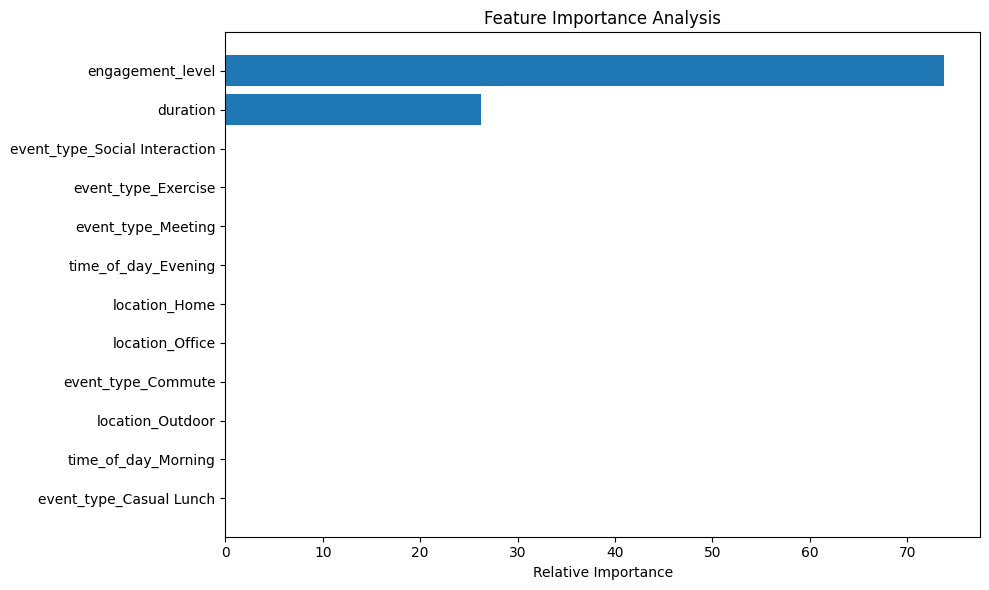


Analysis for High-Stress Scenario:

    Cognitive Load Analysis Report
    ----------------------------
    Risk Level: High
    Risk Score: 91%
    
    Key Risk Factors:
    
- Duration: 120 minutes (high risk)
  Impact: Extended duration increases cognitive load
- Engagement Level: 9/10 (high risk)
  Impact: High mental engagement can lead to faster fatigue

Top Contributing Factors:
- engagement_level: 73.8%
- duration: 26.2%
- event_type_Social Interaction: 0.0%

Recommendations:
1. Use active engagement techniques to maintain focus
2. Use active rest techniques (brief stretching, eye exercises)
3. Use Pomodoro technique (25 min work + 5 min break)
4. Alternate between high and low engagement tasks
5. Include 10 minute breaks between segments
6. Take regular screen breaks
7. Take a short walk after lunch
8. Use varied learning methods
9. Set up proper lighting for video calls
10. Incorporate micro-breaks every 20 minutes
11. Schedule regular reflection periods
12. Break down the 

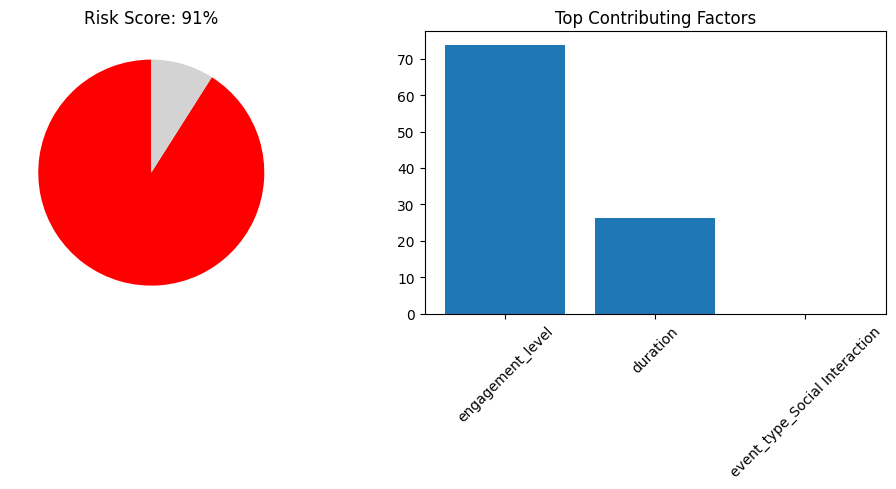

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


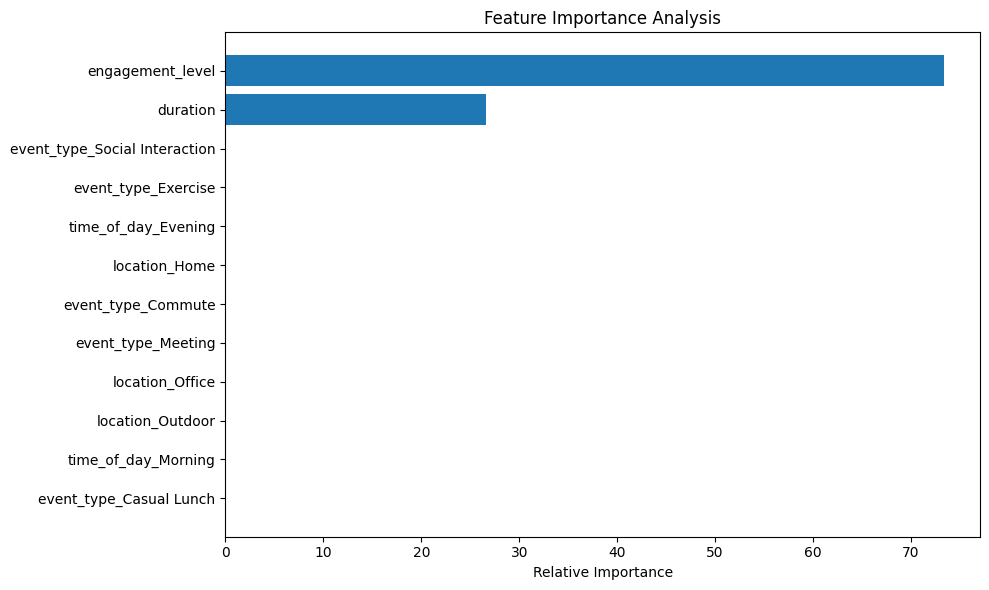


    Cognitive Load Analysis Report
    ----------------------------
    Risk Level: High
    Risk Score: 91%
    
    Key Risk Factors:
    

Top Contributing Factors:
- engagement_level: 73.4%
- duration: 26.6%
- event_type_Social Interaction: 0.0%

Recommendations:
1. Adjust environmental factors (lighting, temperature)
2. Encourage active participation to maintain engagement
3. Find quiet spaces for high-focus work
4. Schedule high-engagement activities
5. Implement 5-minute breaks every 45 minutes
6. Use noise-canceling headphones if needed
7. Utilize peak alertness for complex tasks
8. Use structured agenda to maintain focus


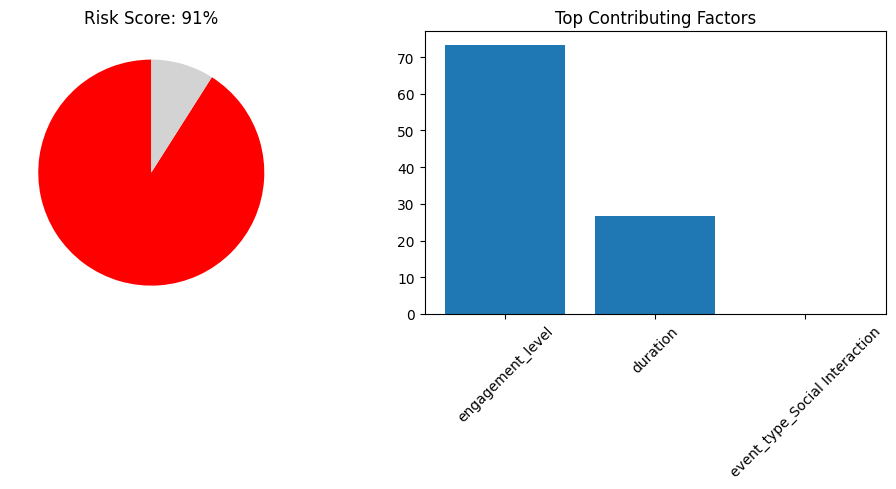


Comparing Risk Scores:
Original Scenario: 91%
High-Stress Scenario: 91%


In [8]:
import shap
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import numpy as np

def analyze_feature_importance(model, X_test):
    def get_feature_importance(model, X):
        # Convert DataFrame to tensor
        X_tensor = tf.convert_to_tensor(X.values, dtype=tf.float32)
        baseline_pred = model.predict(X_tensor, verbose=0)
        importances = {}
        
        # Calculate baseline variance
        baseline_var = np.var(baseline_pred)
        
        for i, column in enumerate(X.columns):
            importance_scores = []
            # Multiple permutations for more stable results
            for _ in range(5):
                X_permuted = X.copy().values
                # Shuffle the column values instead of adding noise
                np.random.shuffle(X_permuted[:, i])
                X_permuted_tensor = tf.convert_to_tensor(X_permuted, dtype=tf.float32)
                permuted_pred = model.predict(X_permuted_tensor, verbose=0)
                
                # Calculate importance using prediction variance
                importance = np.var(baseline_pred - permuted_pred) / (baseline_var + 1e-10)
                importance_scores.append(importance)
            
            # Take the mean importance across permutations
            importances[column] = np.mean(importance_scores)
        
        return importances  # Return raw importances without normalization
    
    # Use a smaller subset for efficiency
    sample_size = min(100, len(X_test))
    X_sample = X_test.head(sample_size)
    
    # Calculate feature importance
    feature_importance = get_feature_importance(model, X_sample)
    
    # Normalize importance scores to sum to 100
    total = sum(feature_importance.values())
    if total > 0:  # Avoid division by zero
        feature_importance = {k: (v/total) * 100 for k, v in feature_importance.items()}
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    importance_df = pd.DataFrame(list(feature_importance.items()), 
                               columns=['Feature', 'Importance'])
    importance_df = importance_df.sort_values('Importance', ascending=True)
    
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.title('Feature Importance Analysis')
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

def predict_and_analyze(input_data, model, scaler, X_test):
    """Main function to predict and provide detailed analysis"""
    # Preprocess input
    processed_input = pd.get_dummies(input_data, columns=['event_type', 'location', 'time_of_day'])
    
    # Ensure all columns from training data are present
    missing_cols = set(X_test.columns) - set(processed_input.columns)
    for col in missing_cols:
        processed_input[col] = 0
    processed_input = processed_input[X_test.columns]
    
    # Scale numerical features
    numerical_features = ['duration', 'engagement_level']
    processed_input[numerical_features] = scaler.transform(processed_input[numerical_features])
    
    # Convert to tensor for prediction
    input_tensor = tf.convert_to_tensor(processed_input.values, dtype=tf.float32)
    
    # Get prediction
    prediction = model.predict(input_tensor)
    probability = prediction[0][0]
    
    # Get feature importance
    feature_importance = analyze_feature_importance(model, X_test)
    
    # Generate detailed analysis
    analysis = generate_recommendations(input_data, probability, feature_importance)
    
    # Create report
    report = f"""
    Cognitive Load Analysis Report
    ----------------------------
    Risk Level: {analysis['risk_level']}
    Risk Score: {analysis['risk_score']}%
    
    Key Risk Factors:
    """
    for factor in analysis['risk_factors']:
        report += f"\n- {factor['factor']}: {factor['value']} ({factor['risk_level']} risk)"
        report += f"\n  Impact: {factor['impact']}"
    
    report += "\n\nTop Contributing Factors:"
    for factor, importance in analysis['primary_contributors']:
        report += f"\n- {factor}: {importance:.1f}%"
    
    report += "\n\nRecommendations:"
    for i, rec in enumerate(analysis['recommendations'], 1):
        report += f"\n{i}. {rec}"
    
    return analysis, report

def analyze_cognitive_patterns(data):
    """Analyze patterns in cognitive load based on different factors"""
    patterns = {
        'time_patterns': data.groupby('time_of_day')['overloaded'].mean(),
        'location_patterns': data.groupby('location')['overloaded'].mean(),
        'event_patterns': data.groupby('event_type')['overloaded'].mean(),
        'duration_correlation': data['duration'].corr(data['overloaded']),
        'engagement_correlation': data['engagement_level'].corr(data['overloaded'])
    }
    return patterns

def generate_recommendations(input_data, prediction_prob, feature_importance):
    """Generate detailed recommendations based on input factors"""
    recommendations = []
    risk_factors = []
    
    # Duration analysis
    duration = input_data['duration'].iloc[0]
    if duration > 60:
        risk_level = 'high' if duration > 90 else 'moderate'
        risk_factors.append({
            'factor': 'Duration',
            'value': f"{duration} minutes",
            'risk_level': risk_level,
            'impact': 'Extended duration increases cognitive load'
        })
        recommendations.extend([
            "Break down the activity into 45-minute segments",
            f"Include {5 if duration <= 90 else 10} minute breaks between segments",
            "Use Pomodoro technique (25 min work + 5 min break)"
        ])

    # Engagement level analysis
    engagement = input_data['engagement_level'].iloc[0]
    if engagement > 7:
        risk_factors.append({
            'factor': 'Engagement Level',
            'value': f"{engagement}/10",
            'risk_level': 'high' if engagement > 8 else 'moderate',
            'impact': 'High mental engagement can lead to faster fatigue'
        })
        recommendations.extend([
            "Incorporate micro-breaks every 20 minutes",
            "Use active rest techniques (brief stretching, eye exercises)",
            "Alternate between high and low engagement tasks"
        ])

    # Time of day analysis
    time_recommendations = {
        'morning': ["Utilize peak alertness for complex tasks",
                   "Schedule high-engagement activities"],
        'afternoon': ["Take a short walk after lunch",
                     "Use active engagement techniques to maintain focus"],
        'evening': ["Reduce screen brightness",
                   "Focus on wrap-up and planning tasks"]
    }
    
    time_of_day = input_data['time_of_day'].iloc[0]
    recommendations.extend(time_recommendations.get(time_of_day, []))

    # Event type specific recommendations
    event_type = input_data['event_type'].iloc[0]
    event_recommendations = {
        'meeting': [
            "Use structured agenda to maintain focus",
            "Implement 5-minute breaks every 45 minutes",
            "Encourage active participation to maintain engagement"
        ],
        'training': [
            "Include practical exercises",
            "Use varied learning methods",
            "Schedule regular reflection periods"
        ],
        'focus_work': [
            "Use time-blocking technique",
            "Minimize distractions",
            "Set clear milestones"
        ]
    }
    recommendations.extend(event_recommendations.get(event_type, []))

    # Location-based recommendations
    location = input_data['location'].iloc[0]
    location_recommendations = {
        'office': [
            "Use noise-canceling headphones if needed",
            "Find quiet spaces for high-focus work",
            "Adjust environmental factors (lighting, temperature)"
        ],
        'home': [
            "Maintain a dedicated workspace",
            "Establish clear work boundaries",
            "Ensure proper ergonomic setup"
        ],
        'remote': [
            "Take regular screen breaks",
            "Maintain virtual social connections",
            "Set up proper lighting for video calls"
        ]
    }
    recommendations.extend(location_recommendations.get(location, []))

    # Calculate risk score (0-100)
    base_risk = prediction_prob * 100
    
    # Apply dampening factor to very high probabilities
    if base_risk > 90:
        risk_score = 90 + (base_risk - 90) * 0.1  # Dampen scores above 90
    else:
        risk_score = base_risk
    
    # Ensure risk score stays within 0-100 range
    risk_score = max(0, min(100, risk_score))
    
    risk_level = 'High' if risk_score > 75 else 'Moderate' if risk_score > 50 else 'Low'
    
    return {
        'overload_probability': prediction_prob,
        'risk_score': int(risk_score),
        'risk_level': risk_level,
        'risk_factors': risk_factors,
        'recommendations': list(set(recommendations)),
        'primary_contributors': sorted(
            feature_importance.items(),
            key=lambda x: x[1],
            reverse=True
        )[:3]
    }

def visualize_analysis(analysis):
    """Create visualizations for the analysis"""
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Risk Score Gauge
    plt.subplot(131)
    risk_color = 'red' if analysis['risk_score'] > 75 else 'orange' if analysis['risk_score'] > 50 else 'green'
    plt.pie([analysis['risk_score'], 100-analysis['risk_score']], 
            colors=[risk_color, 'lightgray'],
            startangle=90)
    plt.title(f"Risk Score: {analysis['risk_score']}%")
    
    # Plot 2: Top Contributors
    plt.subplot(132)
    contributors = analysis['primary_contributors']
    plt.bar([x[0] for x in contributors], [x[1] for x in contributors])
    plt.xticks(rotation=45)
    plt.title("Top Contributing Factors")
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Create sample input data
    sample_input = pd.DataFrame({
        'duration': [45],
        'engagement_level': [7],
        'event_type': ['meeting'],
        'location': ['office'],
        'time_of_day': ['morning']
    })
    # Sample input 2 - High stress scenario
    sample_input_2 = pd.DataFrame({
    'duration': [120],           # 2 hour long session
    'engagement_level': [9],     # Very high engagement
    'event_type': ['training'],  # Training session
    'location': ['remote'],      # Remote work
    'time_of_day': ['afternoon'] # Afternoon session
})

# Run analysis on sample input 2
    analysis_2, report_2 = predict_and_analyze(sample_input_2, model, scaler, X_test)
    print("\nAnalysis for High-Stress Scenario:")
    print(report_2)
    visualize_analysis(analysis_2)
    
    # Note: You'll need to have 'model', 'scaler', and 'X_test' defined before running this
    analysis, report = predict_and_analyze(sample_input, model, scaler, X_test)
    print(report)
    visualize_analysis(analysis)

    # Compare with original sample
    print("\nComparing Risk Scores:")
    print(f"Original Scenario: {analysis['risk_score']}%")
    print(f"High-Stress Scenario: {analysis_2['risk_score']}%")